In [27]:
import os, sys
import re
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from glob import glob
from konlpy.tag import Mecab
from gensim.models.ldamodel import LdaModel
from datetime import datetime
from scipy.special import rel_entr
import warnings


sys.path.append('../')
warnings.filterwarnings('ignore')
mecab = Mecab('C:\mecab\mecab-ko-dic')

# Load Train Data

In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from topic_transformer import *
from tensorboardX import SummaryWriter

In [30]:
def normalize_text(text):
    doublespace_pattern = re.compile('\s+')
    text = str(text)
    text = doublespace_pattern.sub(' ', text)
    return text.strip()

In [31]:
ldamodel_path = r'D:\notebooks\kisdi\lda_100\ldamodel'
ldamodel = LdaModel.load(ldamodel_path)
# train_data = [normalize_text(doc) for doc in doc_list]

In [34]:
model = TopicTransformer_LSTM(output_dim = 100,
                             transformer_model_name='xlm-roberta-base')
model.load_state_dict(torch.load('TT_LSTM_epoch20.pt'))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

# Evaluate

In [35]:
class TestDataset(Dataset):
    def __init__(self, test_docs, num_topics=100):
        self.test_docs = test_docs
        self.num_topics = num_topics

    def __len__(self):
        return len(self.test_docs)

    def __getitem__(self, idx):
        doc = self.test_docs[idx]

        return doc, _

In [36]:
scopus_path = r'D:\data\translated'
scopus_data = pd.read_csv(os.path.join(scopus_path,'scopus_translated.csv'))

In [37]:
test_list_en = []
test_list_ko = []
for i,a in scopus_data.iterrows():
    test_list_en.append(normalize_text(a['abstract']))
    test_list_ko.append(normalize_text(a['translated']))

In [38]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

test_batch_size = 16
test_dataset = TestDataset(test_list_en, num_topics=20)
test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False)

preds_en = []
model.eval()
model.to(device)
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        features, _ = batch
        pred = model(list(features), device=device)
        preds_en.extend([i.cpu().tolist() for i in pred])

100%|██████████| 63/63 [00:04<00:00, 14.30it/s]


In [59]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

test_batch_size = 16
test_dataset = TestDataset(test_list_ko, num_topics=20)
test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False)

preds_ko = []
model.eval()
model.to(device)
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        features, _ = batch
        pred = model(list(features), device=device)
        preds_ko.extend([i.cpu().tolist() for i in pred])

100%|██████████| 63/63 [00:04<00:00, 14.21it/s]


In [39]:
def symm_kl(p,q):
    return 0.5*(sum(rel_entr(p,q)) + sum(rel_entr(q,p)))
ko_corpus = [[word for word in mecab.nouns(i) if len(word)>1] for i in test_list_ko]
preds_lda = []
for i in ko_corpus:
    corpus = ldamodel.id2word.doc2bow(i)
    preds_lda.append([prob for (idx,prob) in ldamodel.get_document_topics(corpus, minimum_probability=1e-5)])
# ko_transformer(en) - ko_transformer(ko) distance
score = 0
for i in range(1000):
    score += symm_kl(preds_en[i], preds_ko[i])
score /= 1000
print(score)
# ko_transformer(en) - ko_lda distance
score = 0
for i in range(1000):
    score += symm_kl(preds_en[i], preds_lda[i])
score /= 1000
print(score)
# ko_transformer(ko) - ko_transformer(ko) distance
score = 0
for i in range(1000):
    score += symm_kl(preds_ko[i], preds_lda[i])
score /= 1000
print(score)

2.1628027575266904
2.4229701393885525
3.9121904706307613


# ntis evaluate

In [41]:
ntis_path = r'D:\data\translated'
ntis_data = pd.read_csv(os.path.join(ntis_path, 'ntis_translated.csv'), encoding='utf-8')

In [42]:
test_list_en = []
test_list_ko = []
for i,a in ntis_data.iterrows():
    test_list_en.append(normalize_text(a['요약문_번역']))
    test_list_ko.append(normalize_text(a['요약문_연구내용']))

In [43]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

test_batch_size = 16
test_dataset = TestDataset(test_list_en, num_topics=20)
test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False)

preds_en = []
model.eval()
model.to(device)
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        features, _ = batch
        pred = model(list(features), device=device)
        preds_en.extend([i.cpu().tolist() for i in pred])

100%|██████████| 63/63 [00:04<00:00, 14.53it/s]


In [44]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

test_batch_size = 16
test_dataset = TestDataset(test_list_ko, num_topics=20)
test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False)

preds_ko = []
model.eval()
model.to(device)
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        features, _ = batch
        pred = model(list(features), device=device)
        preds_ko.extend([i.cpu().tolist() for i in pred])

100%|██████████| 63/63 [00:04<00:00, 15.60it/s]


In [45]:
def symm_kl(p,q):
    return 0.5*(sum(rel_entr(p,q)) + sum(rel_entr(q,p)))
ko_corpus = [[word for word in mecab.nouns(i) if len(word)>1] for i in test_list_ko]
preds_lda = []
for i in ko_corpus:
    corpus = ldamodel.id2word.doc2bow(i)
    preds_lda.append([prob for (idx,prob) in ldamodel.get_document_topics(corpus, minimum_probability=1e-5)])

In [46]:
# ko_transformer(en) - ko_transformer(ko) distance
score = 0
for i in range(1000):
    score += symm_kl(preds_en[i], preds_ko[i])
score /= 1000
print('# ko_transformer(en) - ko_transformer(ko) distance score : {}'.format(score))
# ko_transformer(en) - ko_lda distance
score = 0
for i in range(1000):
    score += symm_kl(preds_en[i], preds_lda[i])
score /= 1000
print('# ko_transformer(en) - ko_lda distance distance score : {}'.format(score))
# ko_transformer(ko) - ko_lda distance
score = 0
for i in range(1000):
    score += symm_kl(preds_ko[i], preds_lda[i])
score /= 1000
print('# ko_transformer(ko) - ko_lda distance score : {}'.format(score))

# ko_transformer(en) - ko_transformer(ko) distance score : 0.0788696254676244
# ko_transformer(en) - ko_lda distance distance score : 2.4316231820520944
# ko_transformer(ko) - ko_lda distance score : 2.4256210543248384


# Show Topic Distribution

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def show_topic_dists(doc_num: int,
                     title: str):
    plt.figure(figsize=(20,12))
    bar_width=0.25
    plt.bar(np.arange(100),
            preds_en[doc_num],
            bar_width,
            color='blue',
            label='Ko_transformer(en)')
    plt.bar(np.arange(100)+bar_width,
            preds_ko[doc_num],
            bar_width,
            color='orange',
            label='Ko_transformer(ko)')
    plt.bar(np.arange(100)+2*bar_width,
            preds_lda[doc_num],
            bar_width,
            color='gray',
            label='Ko_LDA')
    plt.legend()
    plt.title(title)
    plt.show()

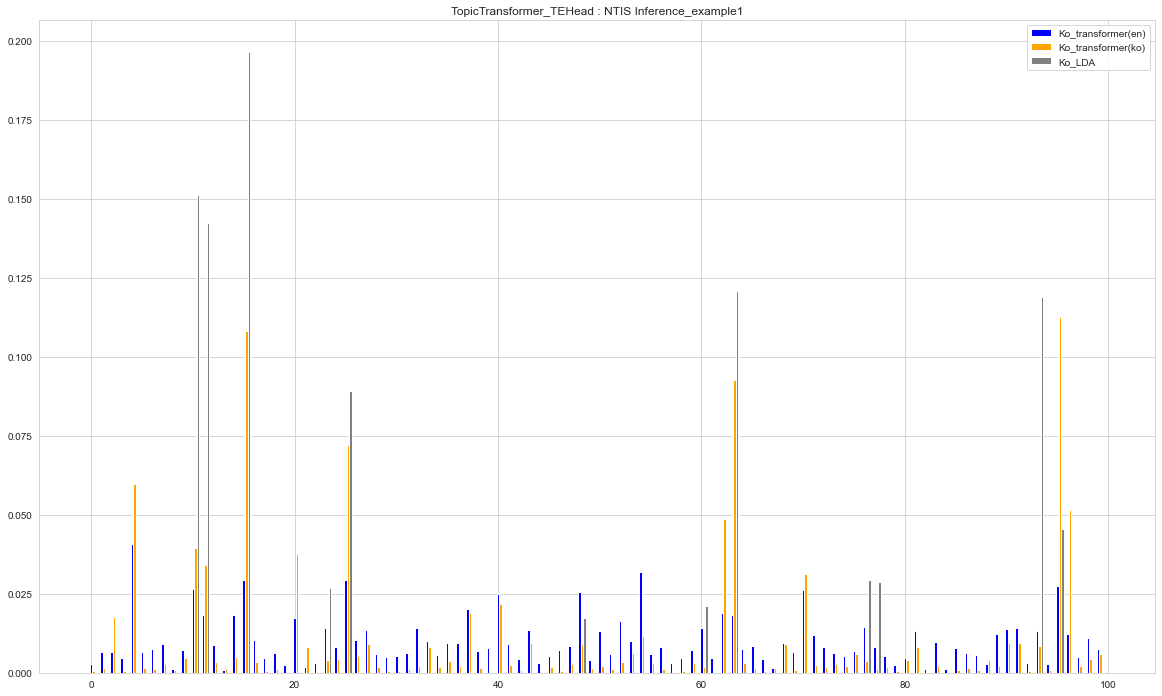

In [20]:
show_topic_dists(10, "TopicTransformer_TEHead : NTIS Inference_example1")

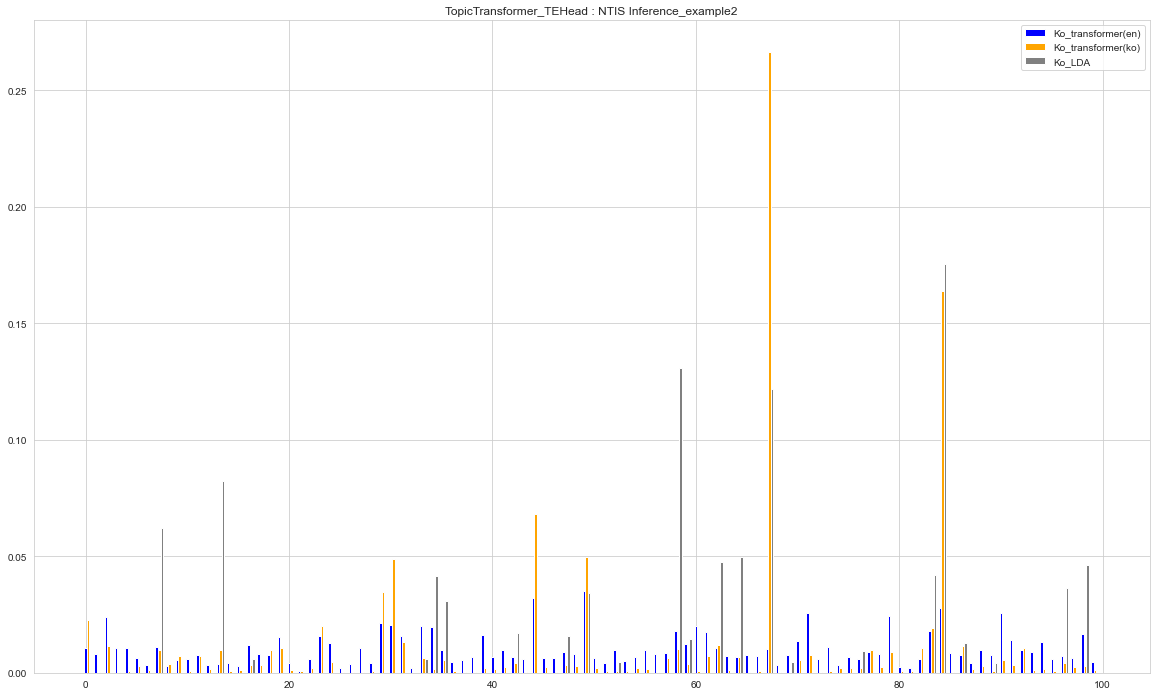

In [21]:
show_topic_dists(1, "TopicTransformer_TEHead : NTIS Inference_example2")

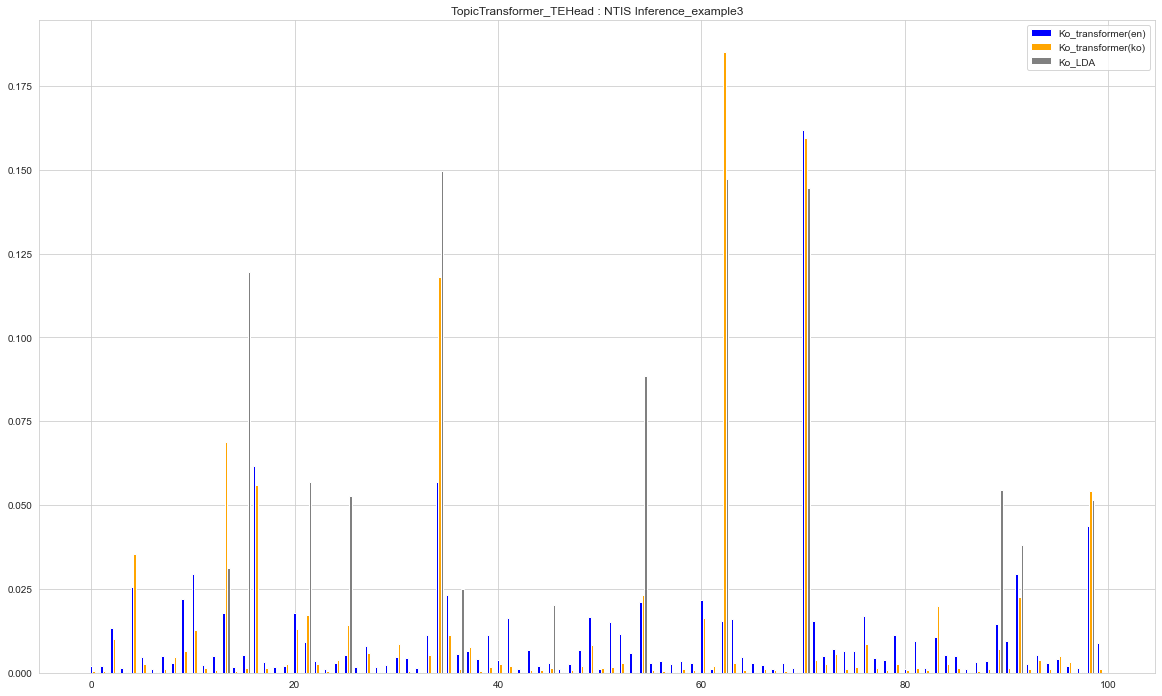

In [22]:
show_topic_dists(0, "TopicTransformer_TEHead : NTIS Inference_example3")